# Classify Handwritten Digits in New Image Data
Image preprocessing and segmentation for feeding new image data to MNIST handwritten digits classifier model.

## Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from skimage.filters import gaussian

from skimage.filters import sobel
from skimage import segmentation

from skimage.measure import regionprops_table
from scipy import ndimage as ndi

import tensorflow as tf

## Read image data
Use OpenCV to read and open image as numpy array.

In [70]:
img = cv.imread('new_handwritten_digits.JPG')
img.shape

(3024, 4032, 3)

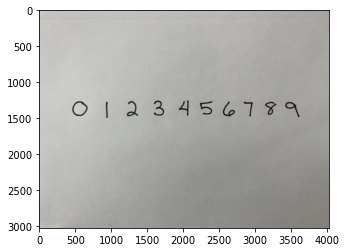

In [71]:
# convert color from BGR to RGB and plot image
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [72]:
# target labels for image data
image_text = "0123456789"
labels = []
for i in image_text:
    labels.append(i)
labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## Image Preprocessing and Segmentation
Functions for preprocessing and segmentation that take in an rgb image and return an array of binary images with size 28x28. 

In [73]:
def image_preprocessing(image):
    # resize image
    re_sized_image = cv.resize(
        image,
        (int(image.shape[1]/2),int(image.shape[0]/2)),
        interpolation= cv.INTER_NEAREST
    )
    # convert image to grayscale
    gray_image = cv.cvtColor(
        re_sized_image,
        cv.COLOR_RGB2GRAY
    )
    # gamma expansion, square root transformation
    gray_image = gray_image**0.5
    return gray_image 

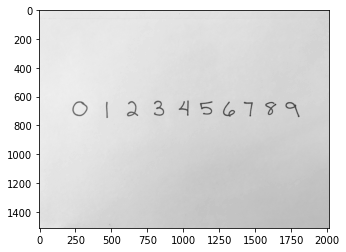

In [74]:
preprocessed_img = image_preprocessing(img)
plt.imshow(preprocessed_img, cmap="gray")
plt.show()

In [75]:
def image_segmentation(preprocessed_image):
    # segment into binary image
    # detect edges and create elevation map using sobel filter from sci-kit image
    elevation_map = sobel(preprocessed_image)
    # create foreground and background markers
    markers = np.zeros_like(preprocessed_image)
    markers[preprocessed_image >= preprocessed_image.mean()] = 1
    markers[preprocessed_image <= preprocessed_image.mean()/1.4] = 2
    # flood elevation map with markers using watershed from ski-kit image segmentation 
    segmented_img = segmentation.watershed(elevation_map, markers)
    return segmented_img

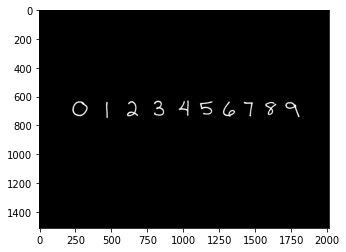

In [76]:
segmented_img = image_segmentation(preprocessed_img)
plt.imshow(segmented_img, cmap="gray")
plt.show()

In [77]:
def get_segment_regions(segmented_image):
    # fill the wholes in segments using scipy ndimage
    filled_segments = ndi.binary_fill_holes(segmented_image - 1)
    # label the filled segments using scipy ndimage
    labeled_segments, _ = ndi.label(filled_segments)
    # create region properties table from labeled segments using regionprops_table from sci-kit image 
    properties =['area', 'label', 'slice', 'bbox', 'bbox_area']
    region_props = regionprops_table(labeled_segments, properties=properties)
    # put region props table in a pandas dataframe
    df = pd.DataFrame(region_props)
    # sort values by their y and x coordinates
    df['y'] = round((df['bbox-0']+df['bbox-2'])/2, -2)
    df['x'] = round((df['bbox-1']+df['bbox-3'])/2, -1)
    df = df.sort_values(by=["y", "x"], ascending=True)
    # filter out small regions and return region slices
    filtered_slices = df['slice'][df['area']>20]
    return filtered_slices

In [78]:
get_segment_regions(segmented_img)

3      (slice(633, 736, None), slice(232, 338, None))
7      (slice(637, 749, None), slice(466, 480, None))
2      (slice(632, 737, None), slice(612, 689, None))
0      (slice(628, 734, None), slice(800, 870, None))
1     (slice(628, 734, None), slice(971, 1040, None))
4    (slice(634, 725, None), slice(1119, 1206, None))
5    (slice(635, 740, None), slice(1279, 1363, None))
6    (slice(636, 738, None), slice(1423, 1487, None))
8    (slice(638, 728, None), slice(1573, 1649, None))
9    (slice(639, 743, None), slice(1712, 1811, None))
Name: slice, dtype: object

In [79]:
# extract the handwritten digits from the segmented image and save to numpy array

def build_digits_array(region_slices, segmented_image):
    # build an empty array to store the sliced images (digits) in
    array_length = len(region_slices)
    digits_array = np.empty((array_length,28,28))

    # slice segmented image and size to 28x28 to match MNIST dataset
    for i in range(len(region_slices)):
        s = region_slices.iloc[i]
        img_slice = segmented_image[s]
        img_slice = ((img_slice>1)*255)/255
        
        # resize array to 20x20 (long edge = 20)
        max_length = np.array(img_slice.shape).max()
        height = int(np.ceil(((img_slice.shape[0]/max_length)*20/2))*2)
        width = int(np.ceil(((img_slice.shape[1]/max_length)*20/2))*2)
        resized = cv.resize(gaussian(img_slice, sigma=0), (width, height), interpolation=cv.INTER_NEAREST)
        
        # pad array to 28x28
        pad_h = int((28-resized.shape[0])/2)
        pad_w = int((28-resized.shape[1])/2)
        padding = ((pad_h, pad_h), (pad_w, pad_w))
        padded_image = np.pad(resized, padding, mode="constant")
        # dilate image to increase 'pen thickness'
        kernel = np.ones((2,2), np.uint8)
        dilated_image = cv.dilate(padded_image, kernel, iterations=1)
        # save array in numbers_array 
        digits_array[i] = np.array(dilated_image)*255

    return digits_array

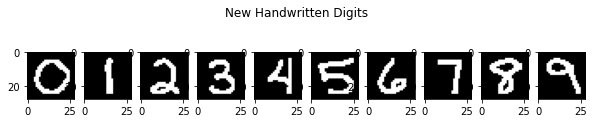

In [82]:
new_handwritten_digits = build_digits_array(get_segment_regions(segmented_img), segmented_img)
plt.figure(figsize=(10,2))
for i, d in enumerate(new_handwritten_digits):
    plt.subplot(1,10,i+1)
    plt.imshow(d, cmap='gray')
    plt.suptitle('New Handwritten Digits')
plt.show()

## Load Handwritten Digits Classifier Model
Load the saved TensorFlow model trained in `digit-recognizer-svc-cnn.ipynb` notebook.

In [83]:
new_model = tf.keras.models.load_model('saved_model/handwritten_digits_cnn')

In [84]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 28)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        8096      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0

## Make predictions
Input array of new handwritten digits and make predictions 

In [86]:
predictions = new_model.predict(new_handwritten_digits)
print(np.argmax(predictions, axis=1))

1/1 [==============================] - 0s 16ms/step
[0 1 2 3 4 5 6 7 8 9]


In [87]:
# print prediction probabilities 
logit_probabilities = []
for i in range(len(predictions)):
    logit_probabilities.append(predictions[i].max())

In [88]:
pd.DataFrame(data=zip(labels, np.argmax(predictions, axis=1), logit_probabilities), columns=['Target', 'Prediction', 'Logit'])

,Target,Prediction,Logit
0,0,0,0.999851
1,1,1,0.997423
2,2,2,0.999950
3,3,3,0.999874
4,4,4,0.996848
5,5,5,0.996411
6,6,6,0.933422
7,7,7,0.987322
8,8,8,0.999997
9,9,9,0.751102
